In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import boxcox
import joblib

In [2]:
df = pd.read_csv('analyzed_data.csv')
y = df.energy_consumption
x = df.drop('energy_consumption', axis=1)
sc_x = pd.DataFrame(StandardScaler().fit_transform(x), columns = x.columns)

In [3]:
def alg_evaluation(x, y):

    alg_dict = {'lr': LinearRegression(),
                'tree': DecisionTreeRegressor(),
                'rf': RandomForestRegressor(),
                'gb': GradientBoostingRegressor(),
                'svm': SVR()}

    alg_list = ['lr', 'tree', 'rf', 'gb', 'svm']
    cv_score_list = []

    for alg in alg_list:
        rm = alg_dict[alg]
        cv_score = cross_val_score(rm, x, y, cv=5)
        cv_score_list.append(cv_score.mean())

    eval_df = pd.DataFrame({'algorithm': alg_list, 'mean_rsq': cv_score_list})
    eval_df = eval_df.sort_values(by = 'mean_rsq', ascending = False).reset_index(drop = True)
    return(eval_df)

In [4]:
alg_evaluation(sc_x, y)

,algorithm,mean_rsq
0,lr,0.997818
1,gb,0.990068
2,rf,0.982740
3,tree,0.943701
4,svm,0.111597


In [5]:
def transform_y (transformation, y, type, lamb=0):
    
    import numpy as np

    if type == 'direct':
        if transformation == 'log':
            trans_y = np.log(y)
            return(trans_y)
        elif transformation == 'sqrt':
            trans_y = np.sqrt(y)
            return(trans_y)
        elif transformation == 'boxcox':
            if lamb == 0:
                print('Missing argument: lambda')
            else:
                trans_y = (y**lamb-1)/lamb
                return(trans_y)
        else:
            print('Applicable transformations: log, sqrt, boxcox')
    elif type == 'inverse':
        if transformation == 'log':
            trans_y = np.exp(y)
            return(trans_y)
        elif transformation == 'sqrt':
            trans_y = y**2
            return(trans_y)
        elif transformation == 'boxcox':
            if lamb == 0:
                print('Missing Argument: lambda')
            else:
                trans_y = (lamb*y + 1)**(1/lamb)
                return(trans_y)
        else:
            print('Applicable transformations: log, sqrt, boxcox')
    else:
        print('Applicable types: direct, inverse')

In [6]:
def trans_evaluation(x, y, model):

    rm = model
    lamb = boxcox(y)[1]
    trans_list = ['base', 'sqrt', 'log', 'boxcox']
    cv_score_list = []

    for trans in trans_list:
        if trans == 'base':
            cv_score = cross_val_score(rm, x, y, cv=5)
            cv_score_list.append(cv_score.mean())
        else:
            trans_y = transform_y(trans, y, 'direct', lamb)
            yhat = cross_val_predict(rm, x, trans_y, cv=5)
            yhat = transform_y(trans, yhat, 'inverse', lamb)
            cv_score_list.append(r2_score(y, yhat))

    eval_df = pd.DataFrame({'transformation': trans_list, 'mean_rsq': cv_score_list})
    eval_df = eval_df.sort_values(by = 'mean_rsq', ascending = False).reset_index(drop = True)
    return(eval_df)

In [7]:
rm = LinearRegression()
trans_evaluation(sc_x, y, rm)

,transformation,mean_rsq
0,boxcox,0.997823
1,base,0.997818
2,sqrt,0.992916
3,log,0.975124


In [8]:
lamb = boxcox(y)[1]
lamb

1.0233885582967104

In [9]:
def train_test_evaluation(x, y, model, n_rounds, transformation = 'base'):
    
    rm = model
    lamb = boxcox(y)[1]
    base_rmse = y.std()
    if transformation != 'base': y = transform_y(transformation, y, 'direct', lamb)
    rsq_list = []
    rrmse_list = []

    for i in range(n_rounds):
        tr_x, te_x, tr_y, te_y = train_test_split(x, y, test_size = 0.25)
        rm.fit(tr_x, tr_y)
        yhat = rm.predict(te_x)
        
        if transformation != 'base':
            te_y = transform_y(transformation, te_y, 'inverse', lamb)
            yhat = transform_y(transformation, yhat, 'inverse', lamb)
            
        rrmse = np.sqrt(mean_squared_error(te_y, yhat))/base_rmse
        rsq = r2_score(te_y, yhat)
        rrmse_list.append(rrmse)
        rsq_list.append(rsq)

    eval_df = pd.DataFrame({'RRMSE': rrmse_list, 'RSQ': rsq_list})
    return(eval_df.describe())

In [10]:
train_test_evaluation(sc_x, y, rm, 10, 'boxcox')

,RRMSE,RSQ
count,10.000000,10.000000
mean,0.046662,0.997773
std,0.001431,0.000179
min,0.044719,0.997465
25%,0.045515,0.997658
50%,0.046369,0.997765
75%,0.047996,0.997866
max,0.048721,0.998099


In [11]:
trans_y = (y**lamb - 1)/lamb
yhat = cross_val_predict(rm, sc_x, trans_y, cv=5)
yhat = (yhat*lamb+1)**(1/lamb)
resid = y - yhat
print('RRMSE: ', np.sqrt(mean_squared_error(y, yhat))/y.std())
print('RSQ: ', r2_score(y, yhat))

RRMSE:  0.04664010731422484
RSQ:  0.9978227210452132


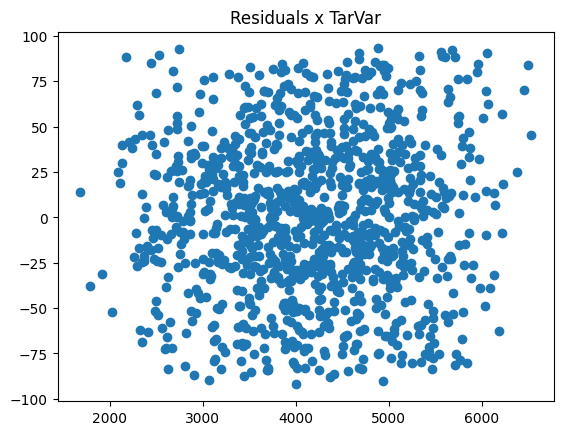

In [12]:
plt.scatter(y, resid)
plt.title('Residuals x TarVar')
plt.show()

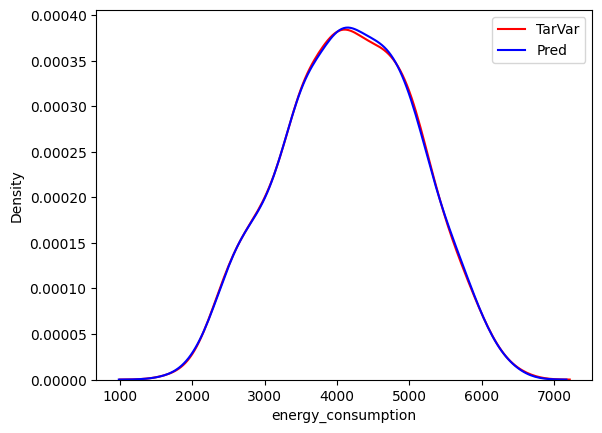

In [13]:
sns.kdeplot(y, color='red')
sns.kdeplot(yhat, color = 'blue')
plt.legend(['TarVar', 'Pred'])
plt.show()

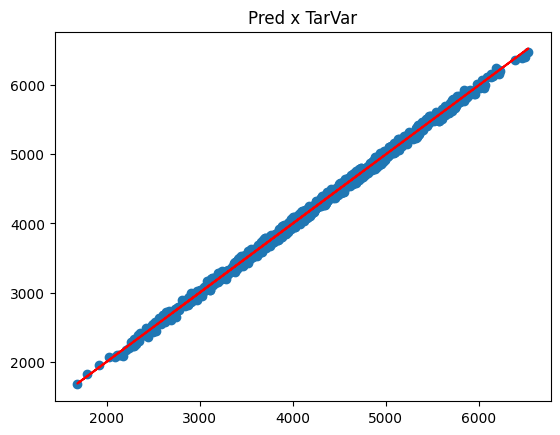

In [14]:
plt.scatter(y, yhat)
plt.plot(y, y, color='red')
plt.title('Pred x TarVar')
plt.show()

In [15]:
final_model = LinearRegression().fit(sc_x, trans_y)
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [19]:
y = pd.read_csv('analyzed_data.csv')['energy_consumption']
y

0       2713.95
1       5744.99
2       4101.24
3       3009.14
4       3279.17
         ...   
1095    3010.81
1096    4248.49
1097    2843.60
1098    3348.39
1099    4722.59
Name: energy_consumption, Length: 1100, dtype: float64